In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Leitura de Arquivos

In [2]:
#Economic Freedom World
path_efw = "efw_cc.csv" 

path_bill = "2022_forbes_billionaires.csv"
path_happy = "Happy_2019.csv"
path_HDI = "Human Development Index.csv"
path_suicide = "Suicide_master.csv"

#Arquivos complementares de PIB e População
path_pop = "populationbycountry19802010millions.csv"
path_GDP = "GDP/gdp.csv"

#Percepção de Corrupção
path_corr = "Corruption/history.csv"

#Melhores Paises para Startups
path_star = "Best Countries/Best Countries for Startups.csv"

#Expectativas de Vida
#path_life = "Life expectancy.csv"

#Gastos Militares em USD
path_militar = "Military Expenditure.csv"

#Salário Mínimo em USD
#path_MW = "MINIMUM_WAGES.csv"


In [3]:
data_efw = pd.read_csv(path_efw, sep=',')

data_bill = pd.read_csv(path_bill, sep=',')
data_happy = pd.read_csv(path_happy, sep=',')
data_HDI = pd.read_csv(path_HDI, sep=',')
data_suicide = pd.read_csv(path_suicide, sep=',')

data_pop = pd.read_csv(path_pop, sep=',', index_col = 0)
data_GDP = pd.read_csv(path_GDP, sep=',', index_col = 0)

data_corr = pd.read_csv(path_corr, sep=',')
data_star = pd.read_csv(path_star, sep=',')
#data_life = pd.read_csv(path_life, sep=',')
data_militar = pd.read_csv(path_militar, sep=',')
#data_MW = pd.read_csv(path_MW, sep=',')


# Primeira vizualização e tratamento dos datasets.

In [59]:
#Escolha dos Países a Serem Analizados
countries = np.array(['Brazil', 'Denmark', 'South Korea', 'New Zealand', 'United States'])#, 'Venezuela'])

In [37]:
#Padronizando Nomes de Estudo
data_efw['countries'] = data_efw['countries'].str.replace('Korea, South', 'South Korea')

data_bill.drop('Unnamed: 0', axis=1, inplace=True)
data_bill.set_index('rank')
data_bill['networth']=data_bill['networth'].str.replace('$','', regex=True)
data_bill['networth']=data_bill['networth'].str.replace(' B','', regex=True)
data_bill['networth']=data_bill['networth'].apply(pd.to_numeric)

data_HDI['Country'][184] = 'Venezuela'
data_HDI['Country'][90] = 'South Korea'

#Removendo Espaços em Branco
data_HDI['Country'] = data_HDI['Country'].str.strip()

data_suicide['country'][data_suicide['country'] == 'Republic of Korea'] = 'South Korea'

data_pop.rename(index={'Korea, South':'South Korea'},inplace=True)

data_GDP.rename(index={'Venezuela, RB':'Venezuela'},inplace=True)
data_GDP.rename(index={'Korea, Rep.':'South Korea'},inplace=True)

data_corr["Country"][data_corr["Country"] == 'The United States of America'] = 'United States'
data_corr["Country"][data_corr["Country"] == 'Korea (South)'] = 'South Korea'

KeyError: "['Unnamed: 0'] not found in axis"

In [39]:
datas = [data_efw,
         data_bill, 
         data_happy, 
         data_HDI, 
         data_suicide, 
         data_pop, 
         data_GDP, 
         data_corr, 
         data_star, 
         #data_life,
         data_militar]
         #data_MW]

In [7]:
# Verificando os dados para Análise
#uni = datas[0].countries.unique()
#print(len(uni[np.in1d(uni, countries)]))
# Apenas o datas[4] e datas[8] não possuem dados sobre Venezuela

# Criação dos Dataframes de Estudo.

In [72]:
DF = []

for x in range(len(countries)): 
    pais = countries[x]

    # Parcela A
    std = datas[0][datas[0]['countries'] == pais].sort_values(by='year')
    std = std.reset_index()
    a = std.drop(columns=['index','ISO_code','countries']) #, inplace=True)

    # Parcela B e C
    b = datas[1][datas[1]['country'] == pais].groupby(['country']).name.count()
    c = datas[1][datas[1]['country'] == pais].groupby(['country']).networth.sum()

    # Parcela D
    d = datas[2][datas[2]['Country or region'] == pais]

    # Parcela E
    std = datas[3][datas[3]['Country'] == pais].iloc[:,2:].transpose()
    std = std.reset_index()
    std.columns = ['year', 'HDI']
    e = std
    e['year'] = e.year.astype(int)


    # Parcela F
    std = datas[4][datas[4]['country'] == pais]
    std = std.drop(columns=['country', 'sex', 'age', 'country-year', 'suicides/100k pop',
                            'population', 'gdp_per_capita ($)', 'generation'])#, inplace=True)

    #std.iloc[:,4].unique()

    std1 = std.iloc[:,:2].groupby(['year']).sum()
    f0 = std1.reset_index()

    f1 = pd.DataFrame(std.groupby(['year'])['HDI for year'].max())
    f2 = pd.DataFrame(std.groupby(['year'])[' gdp_for_year ($) '].max())
    ff = pd.concat([f1, f2], axis=1)
    ff = ff.reset_index()

    f = pd.concat([f0, ff], axis = 1)
    f.columns = ['year', 'suicides_no', 'year_2', 'HDI_2', 'GDP_2']

    f['GDP_2'] = f['GDP_2'].str.replace(',','')
    f['GDP_2'] = f.GDP_2.astype(float)
    f.drop(columns=['year_2'], inplace=True)


    # Parcela G

    std = pd.DataFrame(datas[5].loc[pais])
    std = std.reset_index()
    std.columns = ['year', 'Population']
    g = std
    g['year'] = g.year.astype(int)

    # Parcela H

    std = pd.DataFrame(datas[6].loc[pais][1:])
    std = std.reset_index()
    std.columns = ['year', 'GDP'] #PIB
    h = std.iloc[:-1]
    h['year'] = h.year.astype(int)
    h['GDP'] = h.GDP.astype(float)

    # Parcela I

    std = datas[7][datas[7]['Country'] == pais].iloc[:,4:]
    std.columns = ['2016', '2015', '2014', '2013', '2012']
    std = std.transpose()
    std = std.reset_index()
    std.columns = ['year', 'CPI']
    i = std
    i['year'] = i.year.astype(int)

    # Parcela J

    std = datas[8][datas[8]['country'] == pais].iloc[:,[0,3]].transpose()
    std.columns = ['Startups_Score_2020']
    j = std

    # Parcela K

    std = datas[9][datas[9]['Name'] == pais]
    std = std.iloc[:,4:].transpose()
    std = std.reset_index()
    std.columns = ['year', 'Military_Expenditure_USD']
    k = std
    k['year'] = k.year.astype(int)

    # 0 3 4 5 6 9 - DF por pais
    # Letras - a e f g h k

    # 1 2 7 8 - DF todos os paises
    # Letras - b c d i j

    ### Unindo os Dataframes em um Único.

    df_std = pd.merge(a, e, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, f, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, g, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, h, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, k, how = 'outer', on = 'year')
    df_std = df_std.sort_values(by='year').reset_index(drop=True)
    df_std['HDI_year'] = df_std.loc[:,['HDI','HDI_2']].max(skipna=True, axis=1)
    df_std['GDP_year'] = df_std.loc[:,['GDP','GDP_2']].max(skipna=True, axis=1)

    # Preenchendo os Valores da População Utilizando regressão linear.

    df_inter = df_std.interpolate(method='linear', limit_direction='both', axis=0)
    df = df_inter.loc[:,['year','Population']].dropna(how='any')

    X = pd.DataFrame(df.year)
    y = df.Population

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 1)

    model = LinearRegression(fit_intercept = True)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(pd.DataFrame(df_inter.year))

    df_inter['Population_year'] = ypred

    # Removendo colunas utilizadas 

    df_inter.drop(columns=['HDI','HDI_2','GDP','GDP_2', 'Population'], inplace=True)

    DF.append(df_inter)

In [91]:
DF[0].columns

Index(['year', 'ECONOMIC FREEDOM', 'rank', 'quartile',
       '1a_government_consumption', '1b_transfers', '1c_gov_enterprises',
       '1d_top_marg_tax_rate', '1_size_government', '2a_judicial_independence',
       '2b_impartial_courts', '2c_protection_property_rights',
       '2d_military_interference', '2e_integrity_legal_system',
       '2f_legal_enforcement_contracts', '2g_restrictions_sale_real_property',
       '2h_reliability_police', '2i_business_costs_crime',
       '2j_gender_adjustment', '2_property_rights', '3a_money_growth',
       '3b_std_inflation', '3c_inflation', '3d_freedom_own_foreign_currency',
       '3_sound_money', '4a_tariffs', '4b_regulatory_trade_barriers',
       '4c_black_market', '4d_control_movement_capital_ppl', '4_trade',
       '5a_credit_market_reg', '5b_labor_market_reg', '5c_business_reg',
       '5_regulation', 'suicides_no', 'Military_Expenditure_USD', 'HDI_year',
       'GDP_year', 'Population_year'],
      dtype='object')

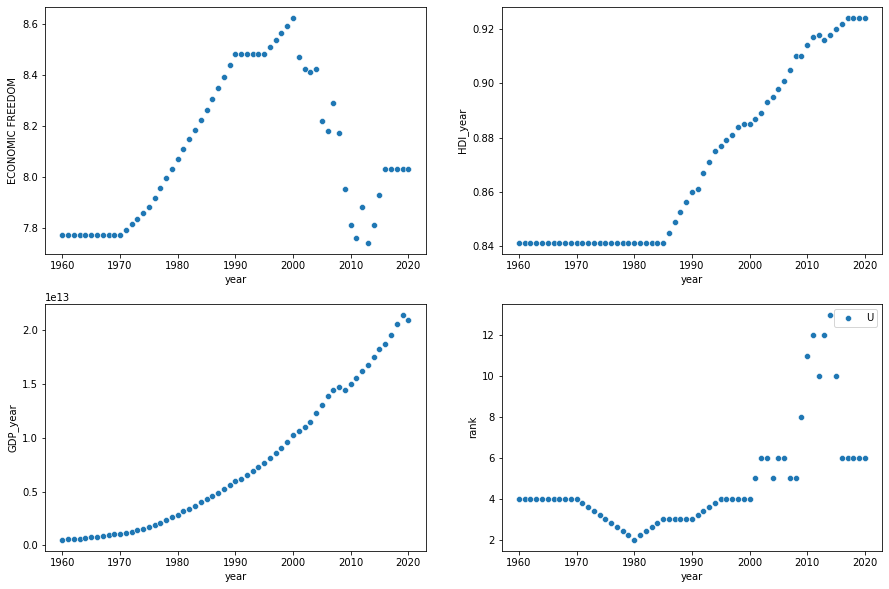

In [105]:
fig, axes = plt.subplots(2, 2, sharex=False, figsize=(15,10))

num = 4
data = DF[num]
cc = countries[num]
sns.scatterplot(ax=axes[0][0], data = data, x = data['year'] , y = data['ECONOMIC FREEDOM'])
sns.scatterplot(ax=axes[0][1], data = data, x = data['year'] , y = data['HDI_year'])
sns.scatterplot(ax=axes[1][0], data = data, x = data['year'] , y = data['GDP_year'])
sns.scatterplot(ax=axes[1][1], data = data, x = data['year'] , y = data['rank'])

plt.legend(labels = cc)